In [1]:
%matplotlib notebook
import cvxpy as cp
import dccp
import torch
import numpy as np
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import svm
from sklearn.metrics import zero_one_loss, confusion_matrix
from scipy.io import arff
import pandas as pd
import time
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)

XDIM = 2
COST = 1/XDIM
TRAIN_SLOPE = 1
EVAL_SLOPE = 5
X_LOWER_BOUND = -10
X_UPPER_BOUND = 10

# Utils

In [2]:
def split_data(X, Y, percentage):
    num_val = int(len(X)*percentage)
    return X[num_val:], Y[num_val:], X[:num_val], Y[:num_val]

def shuffle(X, Y):
    data = torch.cat((X, Y), 1)
    data = data[torch.randperm(data.size()[0])]
    X = data[:, :2]
    Y = data[:, 2]
    return X, Y

def conf_mat(Y1, Y2):
    num_of_samples = len(Y1)
    mat = confusion_matrix(Y1, Y2, labels=[-1, 1])*100/num_of_samples
    acc = np.trace(mat)
    return mat, acc

def calc_accuracy(Y, Ypred):
    num = len(Y)
    temp = Y - Ypred
    acc = len(temp[temp == 0])*1./num
    return acc

# Visualization

In [3]:
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_weights(w1, b1, w2, b2):
    fig = plt.figure()
    plt.bar(np.arange(XDIM + 1), np.append(w1, b1), color='b', alpha=0.5)
    plt.bar(np.arange(XDIM + 1), np.append(w2, b2), color='r', alpha=0.5)
    plt.show()
    
def visualize_data3D(X, Y):
    if not XDIM == 3:
        return
    
    Xpos = X[Y == 1][:100]
    Xneg = X[Y == -1][:100]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='purple')
    plt.show()
    
def visualize_data2D(X, Y):
    if not XDIM == 2:
        return
    
    Xpos = X[Y == 1]
    Xneg = X[Y == -1]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='green')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='purple')
    plt.show()
    
def visualize_data(X, Y):
    if XDIM == 2:
        visualize_data2D(X, Y)
    else:
        visualize_data3D(X, Y)
    
def visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 3:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(Xpos[:, 0], Xpos[:, 1], Xpos[:, 2], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], Xneg[:, 2], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], XposOpt[:, 2], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], XnegOpt[:, 2], marker='_', color='red')

    range_arr = torch.arange(-2, 2 + 1)
    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_non_strategic[0] * xx - w_non_strategic[1] * yy - b_non_strategic) * 1. /w_non_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='blue')

    xx, yy = torch.meshgrid(range_arr, range_arr)
    z = (-w_strategic[0] * xx - w_strategic[1] * yy - b_strategic) * 1. /w_strategic[2]
    ax.plot_surface(xx.numpy(), yy.numpy(), z.numpy(), alpha=0.2, color='red')
#     ax.set_xlim3d(-1.2, 1.2)
#     ax.set_ylim3d(-1.2, 1.2)
#     ax.set_zlim3d(-1.2, 1.2)
#     ax.view_init(25, 45)
#     plt.savefig('plots/simple_strategic_classification.pdf', format='pdf')
#     plt.savefig('plots/simple_strategic_classification.eps', format='eps')
#     plt.savefig('plots/simple_strategic_classification.png', format='png')
    plt.show()

def visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if not XDIM == 2:
        return

    Xpos = Xval[Yval == 1][:50]
    Xneg = Xval[Yval == -1][:50]
    XposOpt = Xval_opt[Yval == 1][:50]
    XnegOpt = Xval_opt[Yval == -1][:50]

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='blue')
    ax.scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='blue')

    ax.scatter(XposOpt[:, 0], XposOpt[:, 1], marker='+', color='red')
    ax.scatter(XnegOpt[:, 0], XnegOpt[:, 1], marker='_', color='red')

    range_arr = torch.arange(-0.5, 2 + 1)
    xx = torch.meshgrid(range_arr)[0]
    z = (-w_non_strategic[0] * xx - b_non_strategic) * 1. /w_non_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='blue')

    xx = torch.meshgrid(range_arr)[0]
    z = (-w_strategic[0] * xx - b_strategic) * 1. /w_strategic[1]
    ax.plot(xx.detach().numpy(), z.detach().numpy(), alpha=0.2, color='red')

    plt.show()
    
def visualize_strategic_data(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic):
    if XDIM == 2:
        visualize_strategic_data2D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
    else:
        visualize_strategic_data3D(Xval, Xval_opt, Yval, w_non_strategic, b_non_strategic, w_strategic, b_strategic)
        
def visualize_training_errors(train_errors, val_errors):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_errors)), np.mean(train_errors, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_errors)), val_errors, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])

    plt.show()
    
def visualize_training_losses(train_losses, val_losses):
    fig = plt.figure()
    train_patch, = plt.plot(torch.arange(len(train_losses)), np.mean(train_losses, axis=1), color='blue', label="train")
    val_patch, = plt.plot(torch.arange(len(val_losses)), val_losses, color='orange', label="validation")
    plt.legend(handles=[train_patch, val_patch])
    
    plt.show()

# Dataset

In [4]:
def gen_custom_data(N, pos_ranges, neg_ranges):
    """
    pos_ranges: a tuple of tensors of length XDIM.
    (scales tensor, offsets tensor)
    """
    torch.manual_seed(0)
    np.random.seed(0)
    pos_samples_num = N//2
    neg_samples_num = N - pos_samples_num
    posX = torch.rand((pos_samples_num, XDIM))*pos_ranges[0] + pos_ranges[1]
    negX = torch.rand((neg_samples_num, XDIM))*neg_ranges[0] + neg_ranges[1]
    
    X = torch.cat((posX, negX), 0)
    Y = torch.unsqueeze(torch.cat((torch.ones(len(posX)), -torch.ones(len(negX))), 0), 1)

    X, Y = shuffle(X, Y)
    return X, Y

def gen_sklearn_data(N, informative_frac=1, shift_range=1, scale_range=1, noise_frac=0.01):
    torch.manual_seed(0)
    np.random.seed(0)
    n_informative = int(informative_frac*XDIM)
    n_redundant = XDIM - n_informative
    shift_arr = shift_range*np.random.randn(XDIM)
    scale_arr = scale_range*np.random.randn(XDIM)
    X, Y = make_classification(n_samples=N, n_features=XDIM, n_informative=n_informative, n_redundant=n_redundant,
                               flip_y=noise_frac, shift=shift_arr, scale=scale_arr, random_state=seed)
    Y[Y == 0] = -1
    return torch.from_numpy(X), torch.from_numpy(Y)


# CCP classes

In [5]:
class CCP:
    def __init__(self, x_dim, funcs):
        self.f_derivative = funcs["f_derivative"]
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.xt = cp.Parameter(x_dim)
        self.r = cp.Parameter(x_dim)
        self.w = cp.Parameter(x_dim)
        self.b = cp.Parameter(1)
        self.slope = cp.Parameter(1)

        target = self.x@self.f_derivative(self.xt, self.w, self.b, self.slope)-self.g(self.x, self.w, self.b, self.slope)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        self.prob = cp.Problem(cp.Maximize(target), constraints)
        
    def ccp(self, r):
        """
        numpy to numpy
        """
        self.xt.value = r
        self.r.value = r
        result = self.prob.solve()
        diff = np.linalg.norm(self.xt.value - self.x.value)
        cnt = 0
        while diff > 0.0001 and cnt < 10:
            cnt += 1
            self.xt.value = self.x.value
            result = self.prob.solve()
            diff = np.linalg.norm(self.x.value - self.xt.value)
        return self.x.value
    
    def optimize_X(self, X, w, b, slope):
        """
        tensor to tensor
        """
        w = w.detach().numpy()
        b = b.detach().numpy()
        slope = np.full(1, slope)
        X = X.numpy()
        
        self.w.value = w
        self.b.value = b
        self.slope.value = slope
        
        return torch.stack([torch.from_numpy(self.ccp(x)) for x in X])

In [11]:
class DELTA():
    
    def __init__(self, x_dim, funcs):
        self.g = funcs["g"]
        self.c = funcs["c"]
        
        self.x = cp.Variable(x_dim)
        self.r = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.w = cp.Parameter(x_dim, value = np.random.randn(x_dim))
        self.b = cp.Parameter(1, value = np.random.randn(1))
        self.f_der = cp.Parameter(x_dim, value = np.random.randn(x_dim))

        target = self.x@self.f_der-self.g(self.x, self.w, self.b, TRAIN_SLOPE)-self.c(self.x, self.r)
        constraints = [self.x >= X_LOWER_BOUND,
                       self.x <= X_UPPER_BOUND]
        objective = cp.Maximize(target)
        problem = cp.Problem(objective, constraints)
        self.layer = CvxpyLayer(problem, parameters=[self.r, self.w, self.b, self.f_der],
                                variables=[self.x])
        
        
    def optimize_X(self, X, w, b, F_DER):
        return self.layer(X, w, b, F_DER)[0]

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Gain & Cost functions

In [12]:
def score(x, w, b):
    return x@w + b

def f(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) + 1)]), 2)

def g(x, w, b, slope):
    return 0.5*cp.norm(cp.hstack([1, (slope*score(x, w, b) - 1)]), 2)

def c(x, r):
    return COST*cp.sum_squares(x-r)

def f_derivative(x, w, b, slope):
    return 0.5*cp.multiply(slope*((slope*score(x, w, b) + 1)/cp.sqrt((slope*score(x, w, b) + 1)**2 + 1)), w)

funcs = {"f": f, "g": g, "f_derivative": f_derivative, "c": c, "score": score}

check = DELTA(XDIM, funcs)

# Data generation

percent of positive samples: 52.0%


<IPython.core.display.Javascript object>


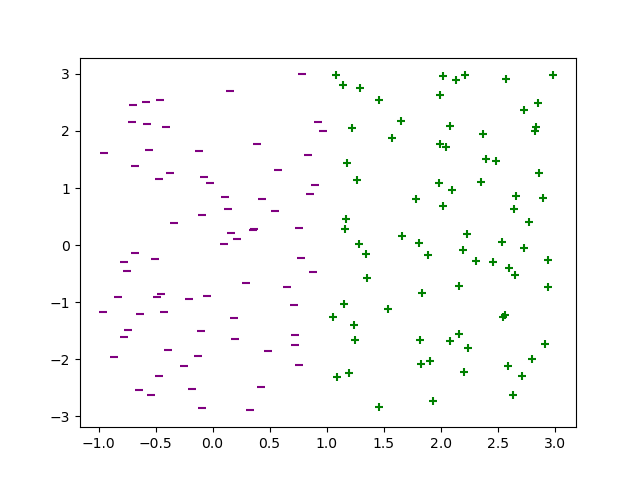

In [8]:
N = 200
X, Y = gen_custom_data(N, (torch.Tensor([2, 6]), torch.Tensor([1, -3])), (torch.Tensor([2, 6]), torch.Tensor([-1, -3])))

assert(len(X[0]) == XDIM)
X, Y, Xval, Yval = split_data(X, Y, 0.25)

print("percent of positive samples: {}%".format(100 * len(Y[Y == 1]) / len(Y)))
visualize_data(X, Y)

# Model

In [9]:
class MyStrategicModel(torch.nn.Module):
    def __init__(self, x_dim, funcs, train_slope, eval_slope, strategic=False):
        torch.manual_seed(0)
        np.random.seed(0)
        super(MyStrategicModel, self).__init__()
        self.x_dim = x_dim
        self.train_slope, self.eval_slope = train_slope, eval_slope
        self.w = torch.nn.parameter.Parameter(math.sqrt(1/x_dim)*(1-2*torch.rand(x_dim, dtype=torch.float64, requires_grad=True)))
        self.b = torch.nn.parameter.Parameter(torch.rand(1, dtype=torch.float64, requires_grad=True))
        self.strategic = strategic
        self.ccp = CCP(x_dim, funcs)
        self.delta = DELTA(x_dim, funcs)

    def forward(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        
        if self.strategic:
            XT = self.ccp.optimize_X(X, self.w, self.b, slope)
            F_DER = self.get_f_ders(XT, slope)
            X_opt = self.delta.optimize_X(X, self.w, self.b, F_DER) # Xopt should equal to XT but we do it again for the gradients

            output = self.score(X_opt)
        else:
            output = self.score(X)        
        
        return output
    
    def optimize_X(self, X, evaluation=False):
        slope = self.eval_slope if evaluation else self.train_slope
        return self.ccp.optimize_X(X, self.w, self.b, slope)
    
    def score(self, x):
        return x@self.w + self.b
    
    def get_f_ders(self, XT, slope):
        return torch.stack([0.5*slope*((slope*self.score(xt) + 1)/torch.sqrt((slope*self.score(xt) + 1)**2 + 1))*self.w for xt in XT])

    def evaluate(self, X, Y):
        Y_pred = torch.sign(self.forward(X, evaluation=True))
        num = len(Y)
        temp = Y - Y_pred
        acc = len(temp[temp == 0])*1./num        
        return acc
    
    def loss(self, Y, Y_pred):
        return torch.mean(torch.clamp(1 - Y_pred * Y, min=0))
    
    def save_model(self, X, Y, Xval, Yval, train_errors, val_errors, train_losses, val_losses, info, path, comment=None):
        if comment is not None:
            path += "_____" + comment
            
        filename = path + "/model.pt"
        if not os.path.exists(os.path.dirname(filename)):
            os.makedirs(os.path.dirname(filename))
        torch.save(self.state_dict(), filename)
        
        pd.DataFrame(X.numpy()).to_csv(path + '/X.csv')
        pd.DataFrame(Y.numpy()).to_csv(path + '/Y.csv')
        pd.DataFrame(Xval.numpy()).to_csv(path + '/Xval.csv')
        pd.DataFrame(Yval.numpy()).to_csv(path + '/Yval.csv')
        
        pd.DataFrame(np.array(train_errors)).to_csv(path + '/train_errors.csv')
        pd.DataFrame(np.array(val_errors)).to_csv(path + '/val_errors.csv')
        pd.DataFrame(np.array(train_losses)).to_csv(path + '/train_losses.csv')
        pd.DataFrame(np.array(val_losses)).to_csv(path + '/val_losses.csv')
        
        with open(path + "/info.txt", "w") as f:
            f.write(info)
    
    def load_model(self, filename):
        self.load_state_dict(torch.load(filename))
        self.eval()
    
    def fit(self, X, Y, Xval, Yval, opt, opt_kwargs={"lr":1e-3}, batch_size=128, epochs=100, verbose=False, callback=None, calc_train_errors=False, comment=None):
        train_dset = TensorDataset(X, Y)
        train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
        opt = opt(self.parameters(), **opt_kwargs)

        train_losses = []
        val_losses = []
        train_errors = []
        val_errors = []
        
        best_val_error = 1
        consecutive_no_improvement = 0
        now = datetime.now()
        path = "C:/Users/sagil/Desktop/nir project/models/" + now.strftime("%d-%m-%Y_%H-%M-%S")

        total_time = time.time()
        for epoch in range(epochs):
            t1 = time.time()
            batch = 1
            train_losses.append([])
            train_errors.append([])
            for Xbatch, Ybatch in train_loader:
                opt.zero_grad()
                Ybatch_pred = self.forward(Xbatch)
                l = self.loss(Ybatch_pred, Ybatch)
                l.backward()
                opt.step()
                train_losses[-1].append(l.item())
                if calc_train_errors:
                    with torch.no_grad():
                        e = self.evaluate(Xbatch, Ybatch)
                        train_errors[-1].append(1-e)
                    if verbose:
                        print("batch %03d / %03d | loss: %3.5f | err: %3.5f" % 
                              (batch, len(train_loader), np.mean(train_losses[-1]), np.mean(train_errors[-1])))
                else:
                    if verbose:
                        print("batch %03d / %03d | loss: %3.5f" %
                              (batch, len(train_loader), np.mean(train_losses[-1])))
                batch += 1
                if callback is not None:
                    callback()

            with torch.no_grad():
                Yval_pred = self.forward(Xval, evaluation=True)
                val_loss = self.loss(Yval_pred, Yval).item()
                val_losses.append(val_loss)
                val_error = 1-self.evaluate(Xval, Yval)
                val_errors.append(val_error)
                if val_error < best_val_error:
                    consecutive_no_improvement = 0
                    best_val_error = val_error
                    if self.strategic:
                        info = "training time in seconds: {}\nepoch: {}\nbatch size: {}\ntrain slope: {}\neval slope: {}\nlearning rate: {}\nvalidation loss: {}\nvalidation error: {}\n".format(
                        time.time()-total_time, epoch, batch_size, self.train_slope, self.eval_slope, opt_kwargs["lr"], val_loss, val_error)
                        self.save_model(X, Y, Xval, Yval, train_errors, val_errors, train_losses, val_losses, info, path, comment)
                        print("model saved!")
                else:
                    consecutive_no_improvement += 1
                    if consecutive_no_improvement >= 4:
                        break
                
            t2 = time.time()
            if verbose:
                print("----- epoch %03d / %03d | time: %03d sec | loss: %3.5f | err: %3.5f" % (epoch + 1, epochs, t2-t1, val_losses[-1], val_errors[-1]))
        print("training time: {} seconds".format(time.time()-total_time)) 
        return train_errors, val_errors, train_losses, val_losses

# Train

In [10]:
EPOCHS = 3
BATCH_SIZE = 16

x_dim = XDIM

# non-strategic classification
print("---------- training non-strategically----------")
non_strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=False)

fit_res_non_strategic = non_strategic_model.fit(X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False)

# strategic classification
print("---------- training strategically----------")
strategic_model = MyStrategicModel(x_dim, funcs, TRAIN_SLOPE, EVAL_SLOPE, strategic=True)

fit_res_strategic = strategic_model.fit(X, Y, Xval, Yval,
                                opt=torch.optim.Adam, opt_kwargs={"lr": (1e-1)},
                                batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=True, calc_train_errors=False,
                                comment=None)

---------- training non-strategically----------
batch 001 / 010 | loss: 0.50893
batch 002 / 010 | loss: 0.57085
batch 003 / 010 | loss: 0.50637
batch 004 / 010 | loss: 0.51723
batch 005 / 010 | loss: 0.53821
batch 006 / 010 | loss: 0.55658
batch 007 / 010 | loss: 0.55602
batch 008 / 010 | loss: 0.53487
batch 009 / 010 | loss: 0.52764
batch 010 / 010 | loss: 0.51713
----- epoch 001 / 003 | time: 000 sec | loss: 0.39244 | err: 0.18000
batch 001 / 010 | loss: 0.10047
batch 002 / 010 | loss: 0.21229
batch 003 / 010 | loss: 0.18721
batch 004 / 010 | loss: 0.20811
batch 005 / 010 | loss: 0.18582
batch 006 / 010 | loss: 0.21330
batch 007 / 010 | loss: 0.21965
batch 008 / 010 | loss: 0.22232
batch 009 / 010 | loss: 0.22179
batch 010 / 010 | loss: 0.23779
----- epoch 002 / 003 | time: 000 sec | loss: 0.20906 | err: 0.04000
batch 001 / 010 | loss: 0.20779
batch 002 / 010 | loss: 0.18986
batch 003 / 010 | loss: 0.18826
batch 004 / 010 | loss: 0.16664
batch 005 / 010 | loss: 0.16195
batch 006 / 01

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\cvxpy\expressions\expression.py:550: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)
C:\Users\sagil\Anaconda3\envs\funcPred\l

batch 001 / 010 | loss: 1.45830
batch 002 / 010 | loss: 1.24050
batch 003 / 010 | loss: 1.22360


KeyboardInterrupt: 

# Test results

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.98
0.98
0.8


<IPython.core.display.Javascript object>


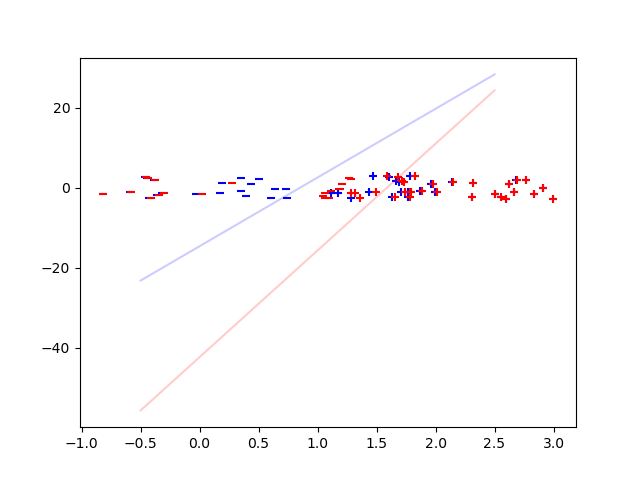

In [205]:
Xval_opt = non_strategic_model.optimize_X(Xval, evaluation=True)
print(non_strategic_model.evaluate(Xval, Yval))
print(strategic_model.evaluate(Xval, Yval))
print(non_strategic_model.evaluate(Xval_opt, Yval))
visualize_strategic_data(Xval, Xval_opt, Yval, non_strategic_model.w, non_strategic_model.b, strategic_model.w, strategic_model.b)